In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

image_size = 28
data_path = "./dataset/"
train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter=",")

In [3]:
print("Number of training datapoints: ",train_data.shape[0])
print("Number of testing datapoints: ",test_data.shape[0])

Number of training datapoints:  60000
Number of testing datapoints:  10000


In [4]:
train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

In [6]:
print("Dimension of reduced dataset: ",train_data_features_reduced.shape[1])

Dimension of reduced dataset:  2


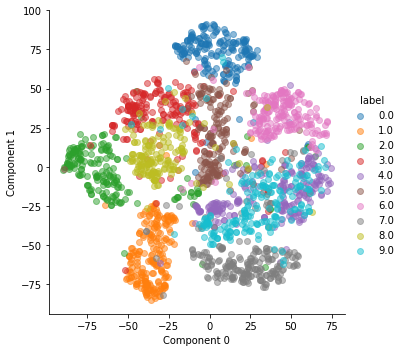

In [8]:
def plot2d(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})

plot2d(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

In [67]:
four_datapoints = []
seven_datapoints = []
for i in range(10000):
    if train_data_labels[i] == 4:                  
        four_datapoints.append(train_data_features_reduced[i])

for i in range(10000):
    if train_data_labels[i] == 7:               
        seven_datapoints.append(train_data_features_reduced[i])
        
four_datapoints = np.array(four_datapoints)
seven_datapoints = np.array(seven_datapoints)

def normalize(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n

four_datapoints_normalized = normalize(four_datapoints, 100, 1)
seven_datapoints_normalized = normalize(seven_datapoints, 100, 1)

In [65]:
from qiskit import *
import numpy as np

import time
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC

In [84]:
train_size = 20
test_size = 10
dp_size_four = 5
dp_size_seven = 5

four_train = four_datapoints_normalized[:train_size]
seven_train = seven_datapoints_normalized[:train_size]

four_test = four_datapoints_normalized[train_size + 1:train_size + test_size + 1]
seven_test = seven_datapoints_normalized[train_size + 1:train_size + test_size + 1]

training_input = {'A':four_train, 'B':seven_train}
test_input = {'A':four_test, 'B':seven_test}

datapoints = []
dp_four = four_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_four]
dp_seven = seven_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_seven]
datapoints.append(np.concatenate((dp_four, dp_seven)))
dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
datapoints.append(dp_y)

class_to_label = {'A': 4, 'B': 7}

In [76]:

seed = 10598
feature_dim = four_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
feature_map.draw()

┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐└───┘»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──■──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     └───┘└─────────────┘                                          └───┘»
«             ┌─────────────┐                                       »
«q_0: ────────┤ P(2.0*x[0]) ├────────────────────────────────────■──»
«             └─────────────┘              ┌───┐┌─────────────┐┌─┴─┐»
«q_1: ──────────────────────────────────■──┤ H ├┤ P(2.0*x[1]) ├┤ X ├»
«     ┌──────────────────────────────┐┌─┴─┐├───┤├─────────────┤└───┘»
«q_2: ┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├┤ H ├┤ P(2.0*x[2]) ├─────»
«     └──────────────────────────────┘└───┘└───┘└─────────────┘     »
«                                               »
«q_0: ──────────────────────────────────■───────»
«     ┌──────────────────────────────┐┌─┴─┐     »
«q_1: ┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──■──»
«     └──────────────────────────────┘└───┘┌─┴─┐»
«q_2: ─────────────────────────────────────┤ X ├»
«                                          └───┘»
«                                          
«q_0: ─────────────────────────────────────
«                                          
«q_1: ──────────────────────────────────■──
«     ┌──────────────────────────────┐┌─┴─┐
«q_2: ┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├
«     └──────────────────────────────┘└───┘

In [77]:
from qiskit.aqua.components.optimizers import COBYLA

cobyla = COBYLA(maxiter=500, tol=0.001)

In [78]:
from qiskit.circuit.library import EfficientSU2, RealAmplitudes

var = EfficientSU2(feature_dim, reps=2)
var.draw()

┌──────────┐┌──────────┐          ┌──────────┐┌──────────┐             »
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[3]) ├──■────■──┤ RY(θ[6]) ├┤ RZ(θ[9]) ├─────────────»
     ├──────────┤├──────────┤┌─┴─┐  │  └──────────┘├──────────┤┌───────────┐»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[4]) ├┤ X ├──┼───────■──────┤ RY(θ[7]) ├┤ RZ(θ[10]) ├»
     ├──────────┤├──────────┤└───┘┌─┴─┐   ┌─┴─┐    ├──────────┤├───────────┤»
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[5]) ├─────┤ X ├───┤ X ├────┤ RY(θ[8]) ├┤ RZ(θ[11]) ├»
     └──────────┘└──────────┘     └───┘   └───┘    └──────────┘└───────────┘»
«               ┌───────────┐┌───────────┐             
«q_0: ──■────■──┤ RY(θ[12]) ├┤ RZ(θ[15]) ├─────────────
«     ┌─┴─┐  │  └───────────┘├───────────┤┌───────────┐
«q_1: ┤ X ├──┼────────■──────┤ RY(θ[13]) ├┤ RZ(θ[16]) ├
«     └───┘┌─┴─┐    ┌─┴─┐    ├───────────┤├───────────┤
«q_2: ─────┤ X ├────┤ X ├────┤ RY(θ[14]) ├┤ RZ(θ[17]) ├
«          └───┘    └───┘    └───────────┘└───────────┘

In [79]:
def call_back_vqc(eval_count, var_params, eval_val, index):
    print("eval_count: {}".format(eval_count))
    print("var_params: {}".format(var_params))
    print("eval_val: {}".format(eval_val))
    print("index: {}".format(index))

In [80]:
backend = BasicAer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, backend_options=backend_options)

vqc = VQC(optimizer=cobyla, feature_map=feature_map, var_form=var, callback=call_back_vqc, training_dataset=training_input, 
         test_dataset=test_input, datapoints=datapoints[0])

In [85]:
start = time.process_time()

result = vqc.run(quantum_instance)

print("time taken: ")
print(time.process_time() - start)


print("testing success ratio: {}".format(result['testing_accuracy']))

eval_count: 0
var_params: [ 0.82921963  0.45064596 -0.92380635 -1.33114818  0.4587782   0.43109766
  0.95466364  0.4381971   0.89369781  0.30344347  1.06088554  0.18471706
 -1.51150743  0.08807489  0.71026463 -0.11759385  0.44665551 -0.16656908]
eval_val: 1.0826393004143227
index: 0
eval_count: 1
var_params: [ 1.82921963  0.45064596 -0.92380635 -1.33114818  0.4587782   0.43109766
  0.95466364  0.4381971   0.89369781  0.30344347  1.06088554  0.18471706
 -1.51150743  0.08807489  0.71026463 -0.11759385  0.44665551 -0.16656908]
eval_val: 0.9693060049990929
index: 1
eval_count: 2
var_params: [ 1.82921963  1.45064596 -0.92380635 -1.33114818  0.4587782   0.43109766
  0.95466364  0.4381971   0.89369781  0.30344347  1.06088554  0.18471706
 -1.51150743  0.08807489  0.71026463 -0.11759385  0.44665551 -0.16656908]
eval_val: 0.6035827647316859
index: 2
eval_count: 3
var_params: [ 1.82921963  1.45064596  0.07619365 -1.33114818  0.4587782   0.43109766
  0.95466364  0.4381971   0.89369781  0.30344347 

eval_count: 29
var_params: [ 2.52388097  1.08274467 -0.95686729 -2.23940975  1.84385528  0.06190695
  0.79737205  0.2809055   0.73640621  0.10663811  0.92710521  0.01050911
 -2.20603543  0.23419184  0.48275256 -0.39894714  0.06960821 -0.38814125]
eval_val: 0.319909261579939
index: 29
eval_count: 30
var_params: [ 2.50242171  1.08503015 -1.01339006 -2.2329002   1.81335598 -0.02721275
  0.84515095  0.3286844   0.78418511  0.16258539  0.97855997  0.061785
 -2.17054347 -0.21264213  0.5450476  -0.32552191  0.33559274 -0.32707412]
eval_val: 0.30682157339436694
index: 30
eval_count: 31
var_params: [ 2.5344047   1.07611932 -0.92401445 -2.23836616  1.85923715  0.44412085
  0.76174748  0.24528093  0.70078164  0.06637917  0.90091459 -0.0270995
 -2.22040176 -0.26400766  0.43889219 -0.44912228  0.42340552 -0.43130497]
eval_val: 0.2837903881854155
index: 31
eval_count: 32
var_params: [ 2.53631416  1.08228109 -0.92492143 -2.24384355  1.86145971  0.44259121
  0.77159602  0.25512947  0.71063018  0.07622

eval_count: 58
var_params: [ 2.24213119  1.45738423 -0.58459483 -2.24638388  1.92106443  0.60117987
  0.33521174  0.24345038  0.68350045  0.34825135  1.03508076  0.02342542
 -2.37035831 -0.42387886  0.18871457 -0.34671853  0.42235136 -0.08323881]
eval_val: 0.2392289172388908
index: 58
eval_count: 59
var_params: [ 2.31651646  1.43349252 -0.57255783 -2.28124962  1.91344582  0.62587896
  0.52603173  0.19835245  0.80521322  0.31474677  1.05301097 -0.08859427
 -2.40794952 -0.45040255  0.19738011 -0.35599121  0.43195849 -0.13266967]
eval_val: 0.24084745177198483
index: 59
eval_count: 60
var_params: [ 2.33054495  1.38975508 -0.58348321 -2.26683099  1.92741674  0.60635342
  0.38007225  0.25825823  0.64032008  0.39663044  1.05509555 -0.03895808
 -2.39238026 -0.48111139  0.19319505 -0.34120213  0.42492039 -0.02138315]
eval_val: 0.23795910122030509
index: 60
eval_count: 61
var_params: [ 2.34589037  1.44620445 -0.47729756 -2.27128818  1.91267743  0.66522911
  0.34304918  0.2491191   0.65235224  0.

eval_count: 87
var_params: [ 2.28198443  1.41202803 -0.54698353 -2.25613793  1.92277192  0.57683596
  0.33329655  0.19898383  0.73897372  0.44360306  1.0032194  -0.01410001
 -2.36537223 -0.42516548  0.21610194 -0.30948416  0.45689863  0.03953143]
eval_val: 0.2365979274619243
index: 87
eval_count: 88
var_params: [ 2.26838661  1.4074417  -0.57292661 -2.21996478  1.93071425  0.57217111
  0.33465498  0.19177624  0.72998514  0.44924914  1.02185749 -0.01462702
 -2.40166966 -0.42010928  0.24603246 -0.31894731  0.4699512   0.04799483]
eval_val: 0.23570506925336673
index: 88
eval_count: 89
var_params: [ 2.27378644  1.40456214 -0.57320533 -2.22189987  1.93116012  0.5720447
  0.33625807  0.19830378  0.72675109  0.42707797  1.02347974 -0.01300862
 -2.40375725 -0.42496086  0.24674204 -0.31864174  0.47007371  0.06681286]
eval_val: 0.2362642083549843
index: 89
eval_count: 90
var_params: [ 2.294673    1.38884981 -0.57648589 -2.22770551  1.92938049  0.57097837
  0.33753394  0.22055911  0.70783076  0.47

eval_count: 116
var_params: [ 2.22832039  1.37300661 -0.53307616 -2.18017602  1.92097098  0.57006876
  0.35256136  0.16595803  0.74110174  0.44242431  1.0617389  -0.00912537
 -2.42133794 -0.45423389  0.24721412 -0.29046105  0.53136036  0.04393856]
eval_val: 0.23390888748515853
index: 116
eval_count: 117
var_params: [ 2.22052616e+00  1.37617687e+00 -5.30321288e-01 -2.17982724e+00
  1.92209726e+00  5.83236471e-01  3.44819680e-01  1.60839924e-01
  7.31097265e-01  4.52501534e-01  1.06627671e+00  2.42368957e-03
 -2.42571618e+00 -4.58614386e-01  2.41439342e-01 -2.90518818e-01
  5.31811530e-01  5.84209717e-02]
eval_val: 0.2338316388174783
index: 117
eval_count: 118
var_params: [ 2.21786267e+00  1.37028655e+00 -5.30273233e-01 -2.18116747e+00
  1.91815460e+00  5.85812321e-01  3.44361054e-01  1.63449277e-01
  7.32247866e-01  4.53114380e-01  1.05935397e+00  1.71922022e-03
 -2.42445989e+00 -4.60060796e-01  2.42866507e-01 -2.92425126e-01
  5.42235333e-01  6.02199948e-02]
eval_val: 0.234132987160924

eval_count: 144
var_params: [ 2.21850369  1.36378509 -0.52152495 -2.18889694  1.92454805  0.58872905
  0.34328897  0.16074856  0.72368774  0.45324703  1.07102761 -0.01067882
 -2.4239723  -0.46854483  0.23442514 -0.27944779  0.54349134  0.05230511]
eval_val: 0.23381929683312816
index: 144
eval_count: 145
var_params: [ 2.21933187  1.38026768 -0.51559813 -2.18705318  1.93005448  0.5921997
  0.34845232  0.16263687  0.71597773  0.45047904  1.07026115 -0.01695068
 -2.42460498 -0.46656649  0.23752593 -0.28005135  0.53816961  0.0516846 ]
eval_val: 0.23412935706172025
index: 145
eval_count: 146
var_params: [ 2.21678842  1.37123795 -0.51574851 -2.18964694  1.92733242  0.58719846
  0.34706477  0.16407453  0.72126765  0.45896352  1.07506536 -0.01497613
 -2.42253333 -0.4649816   0.23673788 -0.28704826  0.53927781  0.04725666]
eval_val: 0.23356454834824325
index: 146
eval_count: 147
var_params: [ 2.21931683  1.37250093 -0.51792377 -2.18829744  1.92523275  0.58707626
  0.34441243  0.16340267  0.72082

eval_count: 173
var_params: [ 2.22068938  1.36300318 -0.5217973  -2.18697078  1.92593199  0.58656524
  0.34388496  0.16563439  0.71448858  0.45746754  1.08160958 -0.01800667
 -2.4220844  -0.46624981  0.23681973 -0.28209874  0.54035256  0.04452939]
eval_val: 0.23317915528986569
index: 173
eval_count: 174
var_params: [ 2.22093726  1.36329377 -0.52170031 -2.18693002  1.9261934   0.58680126
  0.34431763  0.16654699  0.71432521  0.45624495  1.08155227 -0.01812642
 -2.42247647 -0.46652003  0.23617886 -0.28248106  0.54078451  0.04459574]
eval_val: 0.23312814608788734
index: 174
eval_count: 175
var_params: [ 2.22111125  1.36415671 -0.52220231 -2.18733996  1.92777706  0.58775273
  0.3444323   0.16641032  0.71230271  0.45568627  1.08075283 -0.01929871
 -2.42190347 -0.46589428  0.23690973 -0.28133066  0.54204455  0.04440199]
eval_val: 0.23314728270637936
index: 175
eval_count: 176
var_params: [ 2.22081974  1.36306614 -0.52112267 -2.18664455  1.92600017  0.58650334
  0.34446166  0.16679586  0.7147

eval_count: 202
var_params: [ 2.22030161  1.36332228 -0.52090969 -2.18658041  1.92665528  0.58725019
  0.34577915  0.16581132  0.71525865  0.45647825  1.0813968  -0.01830706
 -2.42259106 -0.46678692  0.23410668 -0.28199359  0.54024098  0.04477903]
eval_val: 0.23313830764886848
index: 202
eval_count: 203
var_params: [ 2.22079647  1.36310818 -0.52158405 -2.18698652  1.92633991  0.58674075
  0.34588892  0.16630444  0.71536565  0.45563242  1.08147886 -0.01838872
 -2.42258606 -0.46657247  0.2353142  -0.28144251  0.54060339  0.04402779]
eval_val: 0.23309052841186784
index: 203
eval_count: 204
var_params: [ 2.22079243  1.36323901 -0.52118619 -2.1865878   1.92621663  0.58662388
  0.34608145  0.16686067  0.71514955  0.45510659  1.08172544 -0.01906062
 -2.42246982 -0.46685828  0.23588623 -0.28221728  0.54104182  0.04505473]
eval_val: 0.23316835953568663
index: 204
eval_count: 205
var_params: [ 2.22076817  1.36324688 -0.5217291  -2.1867881   1.92629637  0.58650836
  0.34560006  0.16620143  0.7152

In [86]:
print("prediction of datapoints:")
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], vqc.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))

prediction of datapoints:
ground truth: ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']
prediction:   ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']
